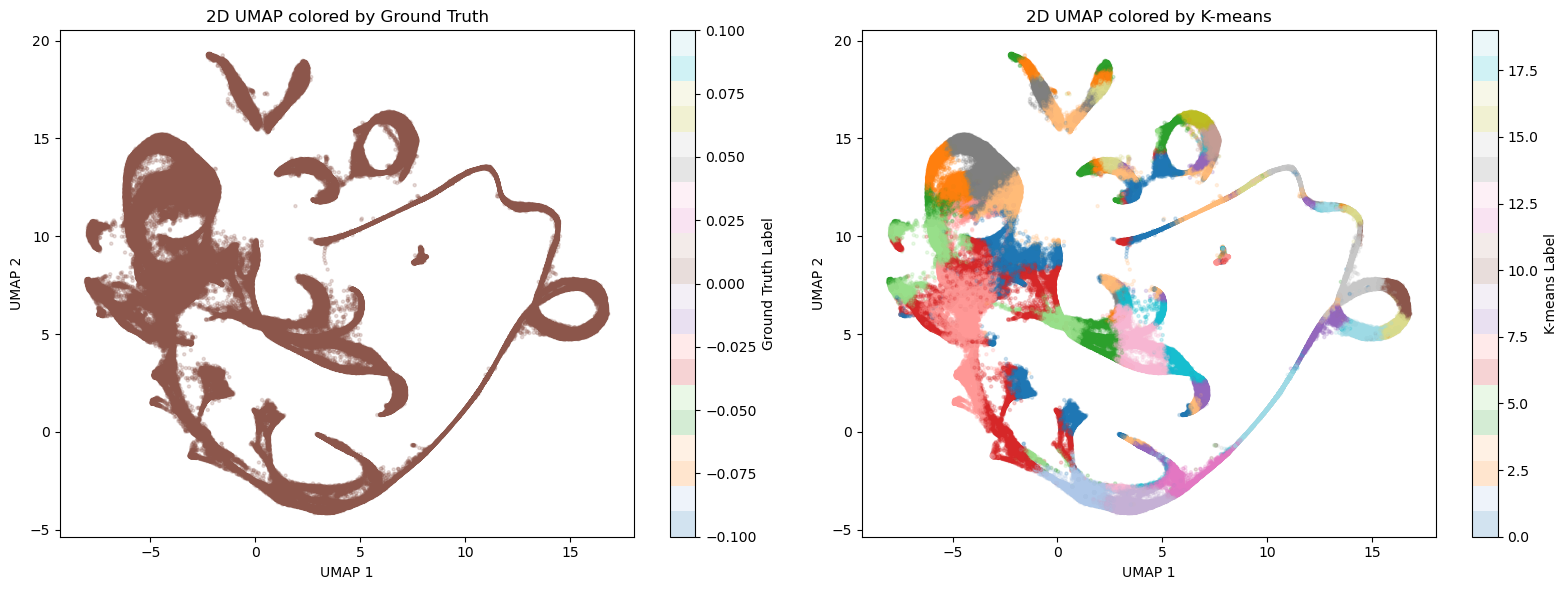

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

f = np.load("files/BF_nickle.npz")

embedding = f["embedding_outputs"][:200_000]
neural_states = f["predictions"][:200_000]
spectogram = f['s'][:200_000]
ground_truth = f["ground_truth_labels"][:200_000]
hdbscan_labels = f["hdbscan_labels"][:200_000]

# Z-score normalize the neural states
scaler = StandardScaler()
neural_states_normalized = scaler.fit_transform(neural_states)

# Apply K-means clustering to normalized neural states
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(neural_states_normalized)

# UMAP the combined features into 2D with cosine metric
umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    metric="cosine",
    n_jobs=-1,
    low_memory=True
).fit_transform(neural_states)

# Plot side by side: Ground Truth vs K-means
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Ground Truth
scatter1 = ax1.scatter(
    umap_2d[:, 0],
    umap_2d[:, 1],
    c=ground_truth,
    cmap="tab20",
    s=5,
    alpha=0.2
)
ax1.set_title("2D UMAP colored by Ground Truth")
ax1.set_xlabel("UMAP 1")
ax1.set_ylabel("UMAP 2")
plt.colorbar(scatter1, ax=ax1, label="Ground Truth Label")

# Plot 2: K-means
scatter2 = ax2.scatter(
    umap_2d[:, 0],
    umap_2d[:, 1],
    c=kmeans_labels,
    cmap="tab20",
    s=5,
    alpha=0.2
)
ax2.set_title("2D UMAP colored by K-means")
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")
plt.colorbar(scatter2, ax=ax2, label="K-means Label")

plt.tight_layout()
plt.show()

## SIMCLR

In [ ]:
"""
minimal SimCLR for pre-computed TweetyBERT latent vectors
--------------------------------------------------------

• each time-bin vector = one instance
• two latent-space augmentations (gaussian noise + dropout)
• NT-Xent loss (SimCLR) to sharpen basins / attractors

edit the **CONFIG** section and run the cell.
"""

# ───────────────────────── CONFIG ──────────────────────────
NPZ_PATH      = "files/BF_nickle.npz"   # path to your .npz
ARRAY_KEY     = "predictions"     # name of (N,D) array inside npz
OUT_FILE      = "simclr_latent.pt"      # where to save weights

EPOCHS        = 10
BATCH_SIZE    = 8192*2
LR            = 3e-3
TEMP          = 0.1                     # NT-Xent temperature
NOISE_STD     = .5                   # σ for gaussian noise
DROPOUT_P     = 0.75                     # dropout prob in latent space
HIDDEN_DIM    = 256                     # encoder MLP width
PROJ_DIM      = 256                     # projection head output dim
# ────────────────────────────────────────────────────────────

import os, math, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# --------------------- augmentations -----------------------
class AddGaussianNoise(nn.Module):
    def __init__(self, std):
        super().__init__()
        self.std = std
    def forward(self, x):
        return x + torch.randn_like(x) * self.std

class RandomDropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
    def forward(self, x):
        if self.p == 0 or not self.training: return x
        mask = torch.rand_like(x) > self.p
        return x * mask / (1 - self.p)

# ----------------------- dataset ---------------------------
# FIX: The dataset now works with a CPU tensor.
class LatentDataset(Dataset):
    def __init__(self, tensor, aug1, aug2):
        self.tensor = tensor
        self.aug1, self.aug2 = aug1, aug2
    def __len__(self):  return self.tensor.size(0)
    def __getitem__(self, i):
        x = self.tensor[i]
        return self.aug1(x), self.aug2(x)

# ----------------------- model -----------------------------
class Encoder(nn.Module):
    def __init__(self, dim_in, dim_hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_in, dim_hidden),
            nn.BatchNorm1d(dim_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden)
        )
    def forward(self, x): return self.net(x)

class ProjectionHead(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim_in, dim_in),
            nn.ReLU(inplace=True),
            nn.Linear(dim_in, dim_out)
        )
    def forward(self, x): return nn.functional.normalize(self.mlp(x), dim=-1)

# ------------------------ loss -----------------------------
def nt_xent(z1, z2, temp):
    """NT-Xent (SimCLR) loss; expects ℓ2-normalised z1/z2"""
    B = z1.size(0)
    z = torch.cat([z1, z2], dim=0)
    sim = z @ z.T / temp
    sim.fill_diagonal_(-torch.inf)
    pos_idx = torch.cat([torch.arange(B, 2*B), torch.arange(B)]).to(z.device)
    log_prob = sim - torch.logsumexp(sim, dim=1, keepdim=True)
    return -log_prob[torch.arange(2*B), pos_idx].mean()

# --------------------- training loop -----------------------
def train():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cpu':
        print("Warning: Training on CPU. Performance will be slow.")

    torch.backends.cudnn.benchmark = True

    try:
        arr = np.load(NPZ_PATH)[ARRAY_KEY].astype(np.float32, copy=False)
    except FileNotFoundError:
        print(f"Error: NPZ file not found at {NPZ_PATH}. Please check the path.")
        return

    # FIX: Create a CPU tensor. We no longer move the whole dataset to the GPU.
    cpu_tensor = torch.from_numpy(arr)

    aug1 = nn.Sequential(AddGaussianNoise(NOISE_STD), RandomDropout(DROPOUT_P))
    aug2 = nn.Sequential(AddGaussianNoise(NOISE_STD), RandomDropout(DROPOUT_P))

    dataset = LatentDataset(cpu_tensor, aug1, aug2)
    
    # FIX: Revert DataLoader settings for CPU-based data loading.
    # We set num_workers=0 for stability in notebooks.
    # pin_memory=True speeds up the CPU-to-GPU transfer for each batch.
    loader  = DataLoader(dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         drop_last=True,
                         num_workers=0,
                         pin_memory=True)

    enc  = Encoder(arr.shape[1], HIDDEN_DIM).to(device)
    proj = ProjectionHead(HIDDEN_DIM, PROJ_DIM).to(device)

    if hasattr(torch, 'compile'):
        print("PyTorch 2.0+ detected. Compiling model...")
        enc = torch.compile(enc)
        proj = torch.compile(proj)

    opt  = torch.optim.AdamW(list(enc.parameters())+list(proj.parameters()), lr=LR)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))

    losses = []
    for epoch in range(1, EPOCHS+1):
        enc.train(); proj.train()
        running_loss = 0.0
        for x1, x2 in tqdm(loader, desc=f"epoch {epoch}/{EPOCHS}", leave=False):
            # FIX: We now have to move each batch to the GPU inside the loop.
            # non_blocking=True allows the CPU to prep the next batch while the
            # GPU computes the current one, working alongside pin_memory=True.
            x1, x2 = x1.to(device, non_blocking=True), x2.to(device, non_blocking=True)
            
            opt.zero_grad(set_to_none=True)

            with torch.autocast(device_type=device, dtype=torch.float16, enabled=(device=='cuda')):
                z1 = proj(enc(x1))
                z2 = proj(enc(x2))

            loss = nt_xent(z1, z2, TEMP)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

            running_loss += loss.item()

        epoch_loss = running_loss/len(loader)
        losses.append(epoch_loss)
        print(f"[epoch {epoch:03d}] loss = {epoch_loss:.4f}")

    enc_state = enc._orig_mod.state_dict() if hasattr(enc, '_orig_mod') else enc.state_dict()
    proj_state = proj._orig_mod.state_dict() if hasattr(proj, '_orig_mod') else proj.state_dict()

    torch.save({'encoder': enc_state, 'proj': proj_state}, OUT_FILE)
    print(f"✓ model saved → {OUT_FILE}")

    # Plot training loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, EPOCHS+1), losses, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('SimCLR Training Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ------------------------- run -----------------------------
train()

## Triplet Loss

epoch 1/5:   0%|          | 0/37 [00:00<?, ?it/s]

[epoch 001] loss = 0.7910


epoch 2/5:   0%|          | 0/37 [00:00<?, ?it/s]

[epoch 002] loss = 0.7014


epoch 3/5:   0%|          | 0/37 [00:00<?, ?it/s]

[epoch 003] loss = 0.6736


epoch 4/5:   0%|          | 0/37 [00:00<?, ?it/s]

[epoch 004] loss = 0.6633


epoch 5/5:   0%|          | 0/37 [00:00<?, ?it/s]

[epoch 005] loss = 0.6570
✓ model saved → triplet_latent.pt


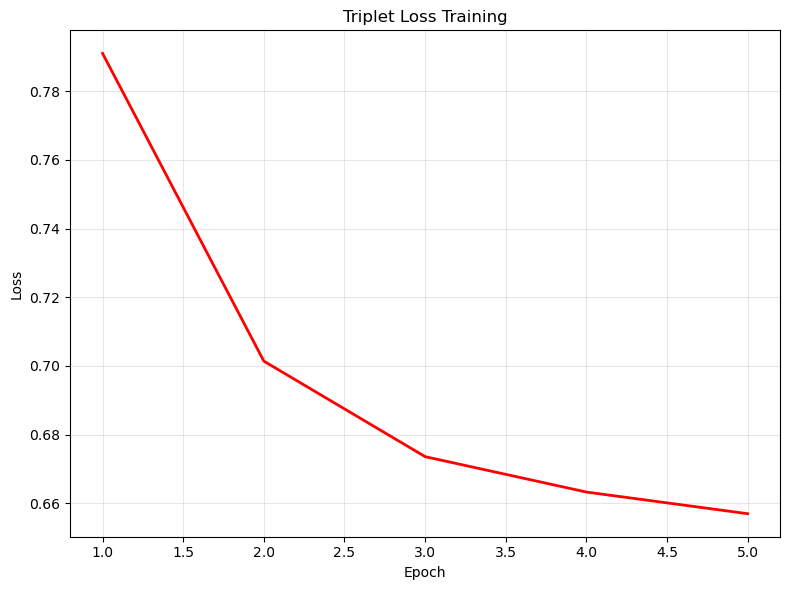

In [45]:
"""
minimal Triplet-Loss trainer for pre-computed TweetyBERT latent vectors
----------------------------------------------------------------------

• anchor  = raw frame latent
• positive= same frame with latent-space aug (noise + dropout)
• negative= random frame at least 100 indices away (≳ 1 s)

Change **CONFIG** then run the cell.
"""

# ───────────────────────── CONFIG ──────────────────────────
NPZ_PATH      = "files/BFTEST.npz"     # path to your .npz
ARRAY_KEY     = "predictions"             # (N,D) latent array name
OUT_FILE      = "triplet_latent.pt"       # where to save weights

EPOCHS        = 5
BATCH_SIZE    = 4096                      # big but < dataset/4
LR            = 5e-3
MARGIN        = 1.5                      # triplet margin (cos/L2)
NOISE_STD     = 0.25                      # σ for gaussian noise
DROPOUT_P     = 0.25                      # dropout prob in latent space
HIDDEN_DIM    = 256                       # encoder MLP width
PROJ_DIM      = 64                       # projection head output dim
NEG_OFFSET    = 1000                       # |idx_neg – idx_anchor| ≥ this
# ────────────────────────────────────────────────────────────

import numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt, math

# --------------------- augmentations -----------------------
class AddGaussianNoise(nn.Module):
    def __init__(self, std): super().__init__(); self.std = std
    def forward(self, x):     return x + torch.randn_like(x) * self.std

class RandomDropout(nn.Module):
    def __init__(self, p): super().__init__(); self.p = p
    def forward(self, x):
        if self.p == 0 or not self.training: return x
        mask = torch.rand_like(x) > self.p
        return x * mask / (1 - self.p)

# ----------------------- dataset ---------------------------
class TripletDataset(Dataset):
    def __init__(self, tensor, aug, neg_offset):
        self.tensor, self.aug, self.K = tensor, aug, neg_offset
        self.N = tensor.size(0)
    def __len__(self): return self.N
    def __getitem__(self, i):
        anchor = self.tensor[i]
        positive = self.aug(anchor.clone())
        # choose a negative at least K frames away
        j = (i + torch.randint(self.K, self.N - self.K, ()).item()) % self.N
        negative = self.tensor[j]
        return anchor, positive, negative

# ----------------------- model -----------------------------
class Encoder(nn.Module):
    def __init__(self, dim_in, dim_hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_in, dim_hidden),
            nn.BatchNorm1d(dim_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden)
        )
    def forward(self, x): return self.net(x)

class ProjectionHead(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim_in, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, dim_out)
        )
    def forward(self, x): return nn.functional.normalize(self.mlp(x), dim=-1)

# ------------------------ loss -----------------------------
def triplet_loss(a, p, n, margin=MARGIN):
    d_ap = (a - p).pow(2).sum(1)
    d_an = (a - n).pow(2).sum(1)
    return torch.relu(d_ap - d_an + margin).mean()

# --------------------- training loop -----------------------
def train():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    torch.backends.cudnn.benchmark = True

    arr = np.load(NPZ_PATH)[ARRAY_KEY].astype(np.float32, copy=False)
    
    # Z-score normalize the features
    mean = arr.mean(axis=0, keepdims=True)
    std = arr.std(axis=0, keepdims=True)
    arr = (arr - mean) / (std + 1e-8)  # add small epsilon to avoid division by zero
    
    cpu_tensor = torch.from_numpy(arr)

    aug = nn.Sequential(
        AddGaussianNoise(NOISE_STD),
        RandomDropout(DROPOUT_P)
    )
    loader = DataLoader(
        TripletDataset(cpu_tensor, aug, NEG_OFFSET),
        batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
        num_workers=0, pin_memory=True
    )

    enc  = Encoder(arr.shape[1], HIDDEN_DIM).to(device)
    proj = ProjectionHead(HIDDEN_DIM, PROJ_DIM).to(device)
    if hasattr(torch, 'compile'):
        enc, proj = torch.compile(enc), torch.compile(proj)

    opt = torch.optim.AdamW(list(enc.parameters()) + list(proj.parameters()), lr=LR)
    scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))

    losses = []
    for epoch in range(1, EPOCHS + 1):
        enc.train(); proj.train()
        running = 0.0
        for a, p, n in tqdm(loader, desc=f"epoch {epoch}/{EPOCHS}", leave=False):
            a, p, n = [x.to(device, non_blocking=True) for x in (a, p, n)]
            
            # ── apply latent mixup on the batch of positives ──
            idx = torch.randperm(p.size(0), device=p.device)
            lam = torch.distributions.Beta(0.4, 0.4).sample([p.size(0), 1]).to(p.device)
            p = lam * p + (1 - lam) * p[idx]
            # ─────────────────────────────────────────────────
            
            opt.zero_grad(set_to_none=True)
            with torch.autocast(device_type=device, dtype=torch.float16, enabled=(device == 'cuda')):
                z_a = proj(enc(a))
                z_p = proj(enc(p))
                z_n = proj(enc(n))
                loss = triplet_loss(z_a, z_p, z_n, MARGIN)

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            running += loss.item()

        epoch_loss = running / len(loader)
        losses.append(epoch_loss)
        print(f"[epoch {epoch:03d}] loss = {epoch_loss:.4f}")

    torch.save(
        {
            'encoder': enc._orig_mod.state_dict() if hasattr(enc,'_orig_mod') else enc.state_dict(),
            'proj'   : proj._orig_mod.state_dict() if hasattr(proj,'_orig_mod') else proj.state_dict()
        }, OUT_FILE)
    print(f"✓ model saved → {OUT_FILE}")

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, EPOCHS + 1), losses, 'r-', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Triplet Loss Training')
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# ------------------------- run -----------------------------
train()


Running UMAP on projection head embeddings...
UMAP complete (projection).
Running HDBSCAN to find clusters...
HDBSCAN complete.


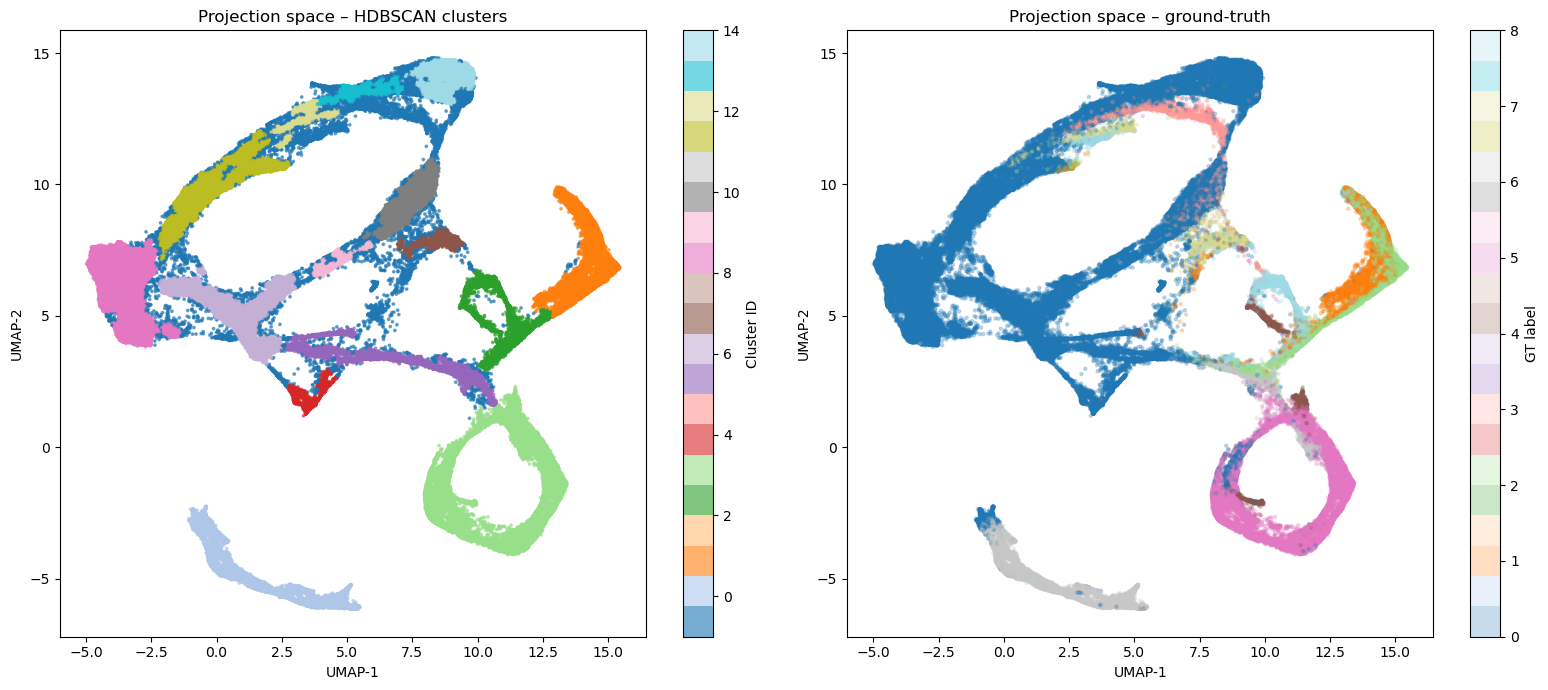

In [46]:
# %% [second cell] UMAP visualisation in **projection** space
import numpy as np, torch, umap
import matplotlib.pyplot as plt, hdbscan
import math

# ───────────────────── CONFIG ──────────────────────
NPZ_PATH       = "files/BFTEST.npz"
ARRAY_KEY      = "predictions"
LABEL_KEY      = "ground_truth_labels"  # optional
MODEL_FILE     = "triplet_latent.pt"
BATCH_SIZE     = 4096
N_NEIGH        = 30
N_SAMPLES      = 100_000
HIDDEN_DIM     = 256
PROJ_DIM       = 64     # ← match your triplet head
MIN_CLUSTER_SIZE = 1000
MIN_SAMPLES      = 50
# ────────────────────────────────────────────────────

# 1) load raw latents + (optional) labels
npz    = np.load(NPZ_PATH)
data   = npz[ARRAY_KEY][:N_SAMPLES]
labels = npz[LABEL_KEY][:N_SAMPLES] if LABEL_KEY and LABEL_KEY in npz else None

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2) rebuild encoder & projection head, then load weights
class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim_in, dim_hidden),
            torch.nn.BatchNorm1d(dim_hidden),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(dim_hidden, dim_hidden)
        )
    def forward(self, x): return self.net(x)

class ProjectionHead(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(dim_in, 128),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(64, dim_out)
        )
    def forward(self, x): return torch.nn.functional.normalize(self.mlp(x), dim=-1)

enc  = Encoder(data.shape[1], HIDDEN_DIM).to(device).eval()
proj = ProjectionHead(HIDDEN_DIM, PROJ_DIM).to(device).eval()

# load saved weights
ckpt = torch.load(MODEL_FILE, map_location=device)
enc.load_state_dict(ckpt['encoder'])
proj.load_state_dict(ckpt['proj'])

# 3) run data through encoder → projection head
out_proj = []
with torch.inference_mode():
    for i in range(0, len(data), BATCH_SIZE):
        x = torch.from_numpy(data[i:i+BATCH_SIZE]).float().to(device)
        h = enc(x)                 # (B, HIDDEN_DIM)
        z = proj(h)                # (B, PROJ_DIM), ℓ₂-normalized
        out_proj.append(z.cpu())
latents_proj = torch.cat(out_proj).numpy()  # (N, PROJ_DIM)

# 4) UMAP on projection-head outputs
print("Running UMAP on projection head embeddings...")
umap_proj = umap.UMAP(
    n_components=2,
    n_neighbors=N_NEIGH,
    metric="cosine",
    min_dist=0.0,
    low_memory=True,
    n_jobs=-1
).fit_transform(latents_proj)
print("UMAP complete (projection).")

# 5) HDBSCAN on the 2-D embedding
print("Running HDBSCAN to find clusters...")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=MIN_CLUSTER_SIZE,
    min_samples=MIN_SAMPLES,
    metric='euclidean'
)
cluster_labels_proj = clusterer.fit_predict(umap_proj)
print("HDBSCAN complete.")

# 6) Plot
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

# projection space clusters
sc0 = axs[0].scatter(
    umap_proj[:, 0], umap_proj[:, 1],
    c=cluster_labels_proj, cmap="tab20", s=3, alpha=0.6
)
axs[0].set_title("Projection space – HDBSCAN clusters")
axs[0].set_xlabel("UMAP-1"); axs[0].set_ylabel("UMAP-2")
plt.colorbar(sc0, ax=axs[0], label="Cluster ID")

# projection space ground truth
if labels is not None:
    sc1 = axs[1].scatter(
        umap_proj[:, 0], umap_proj[:, 1],
        c=labels, cmap="tab20", s=5, alpha=0.25
    )
    axs[1].set_title("Projection space – ground-truth")
    axs[1].set_xlabel("UMAP-1"); axs[1].set_ylabel("UMAP-2")
    plt.colorbar(sc1, ax=axs[1], label="GT label")
else:
    axs[1].set_visible(False)

plt.tight_layout()
plt.show()


## Update this !

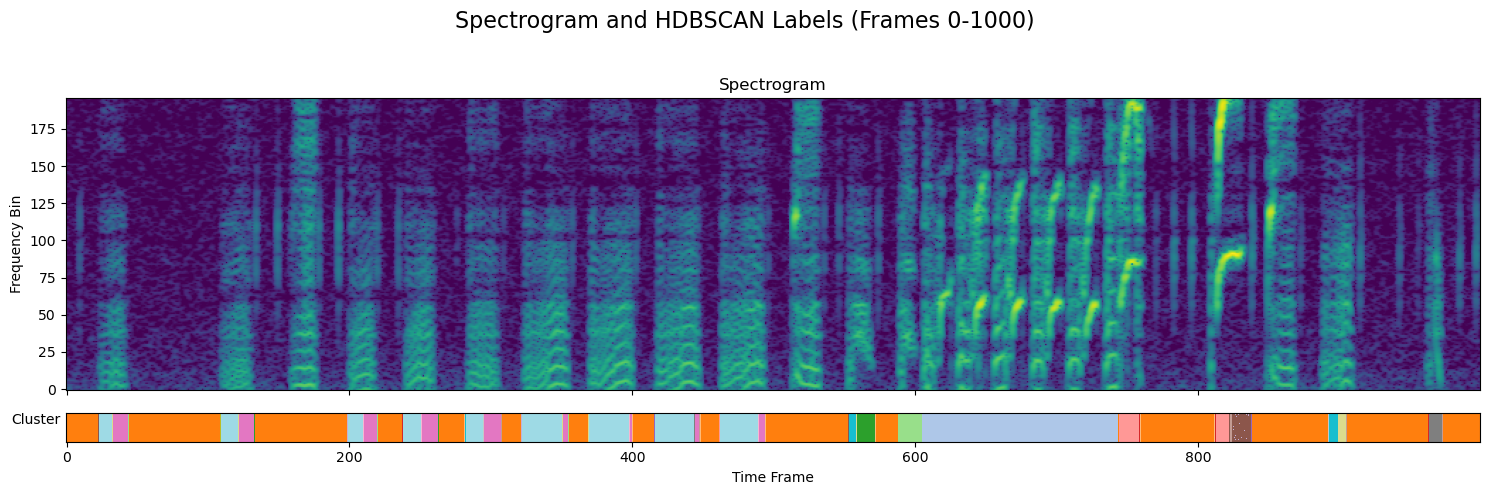

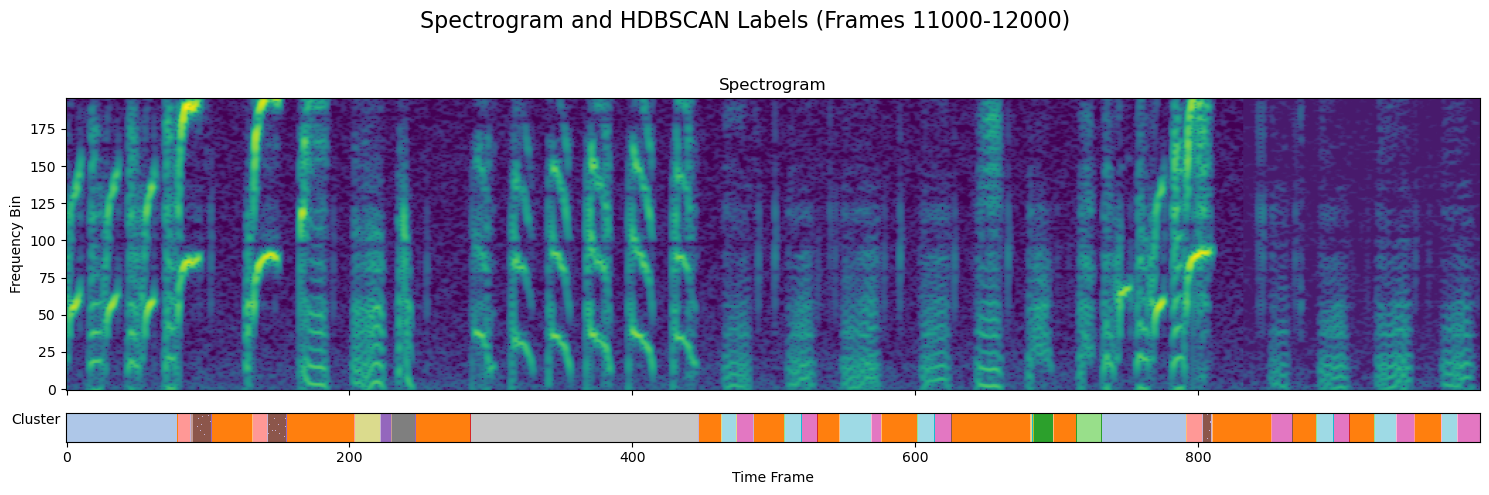

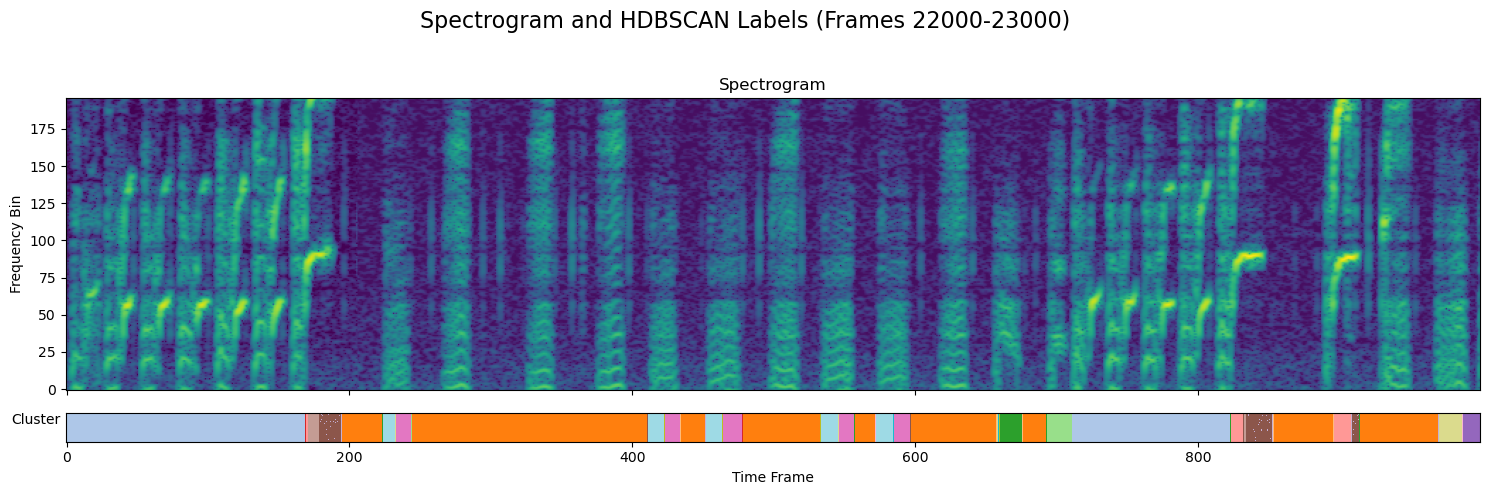

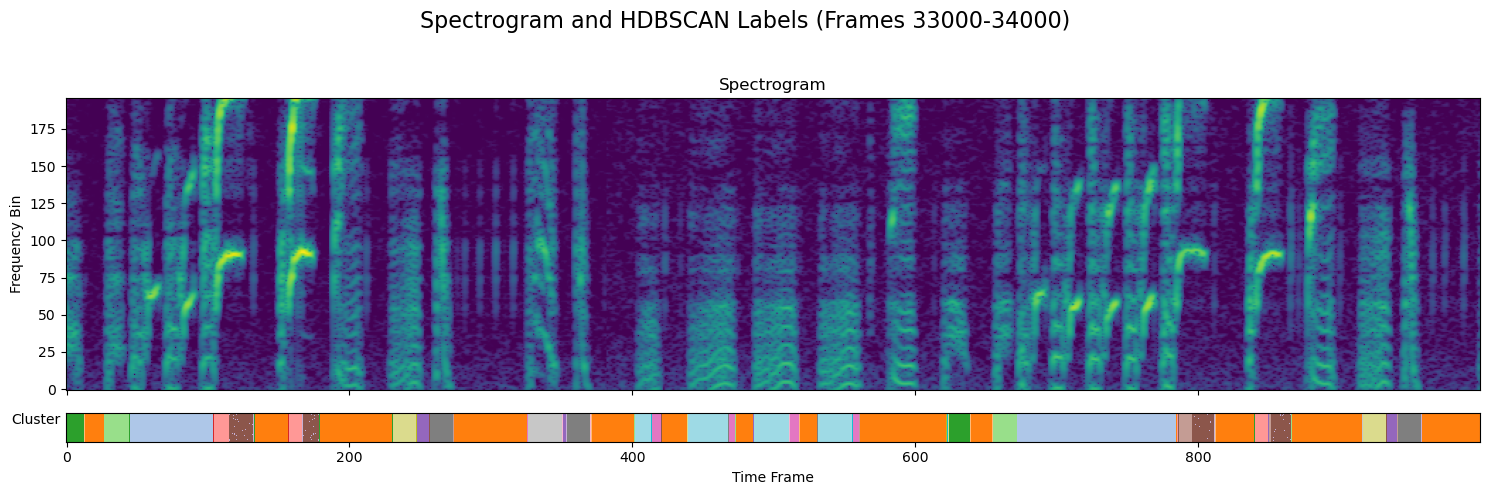

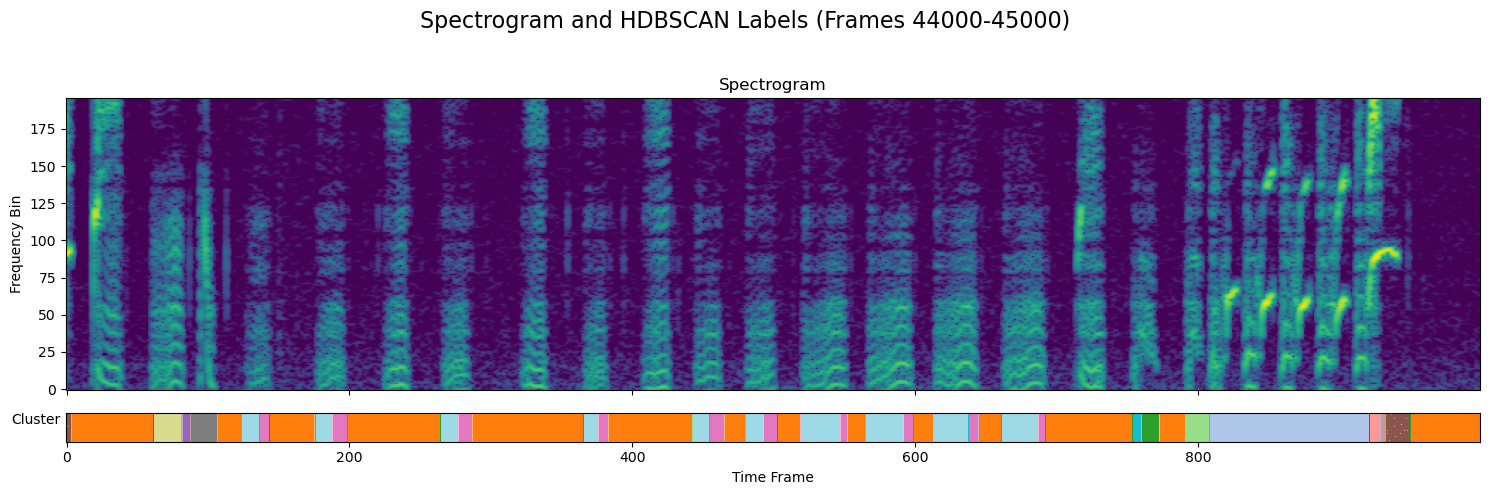

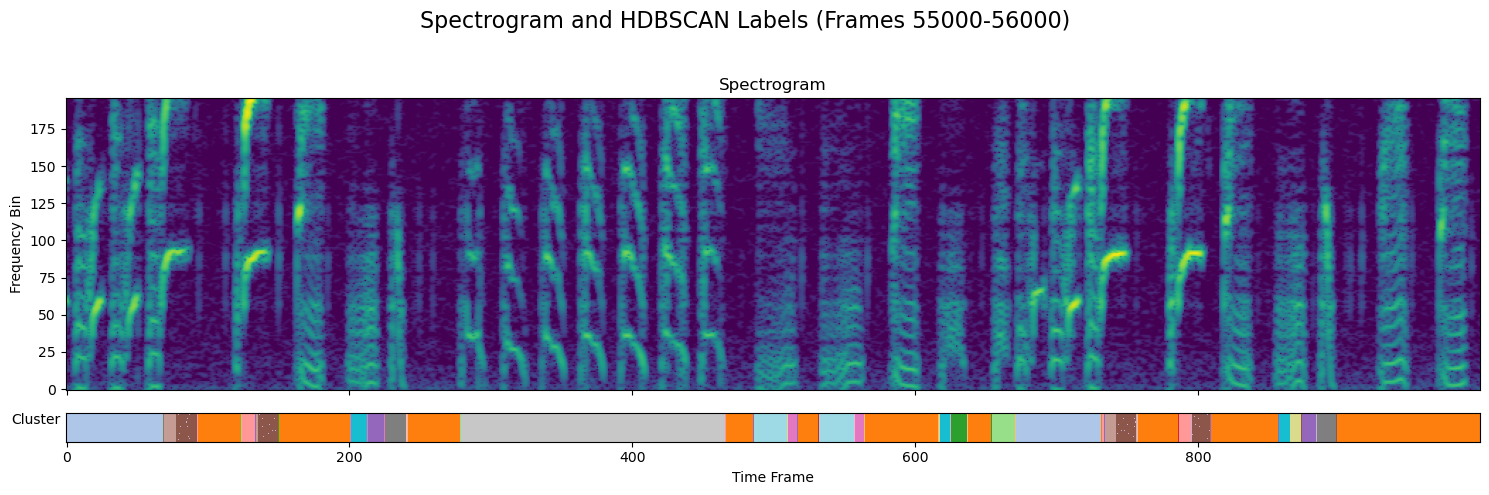

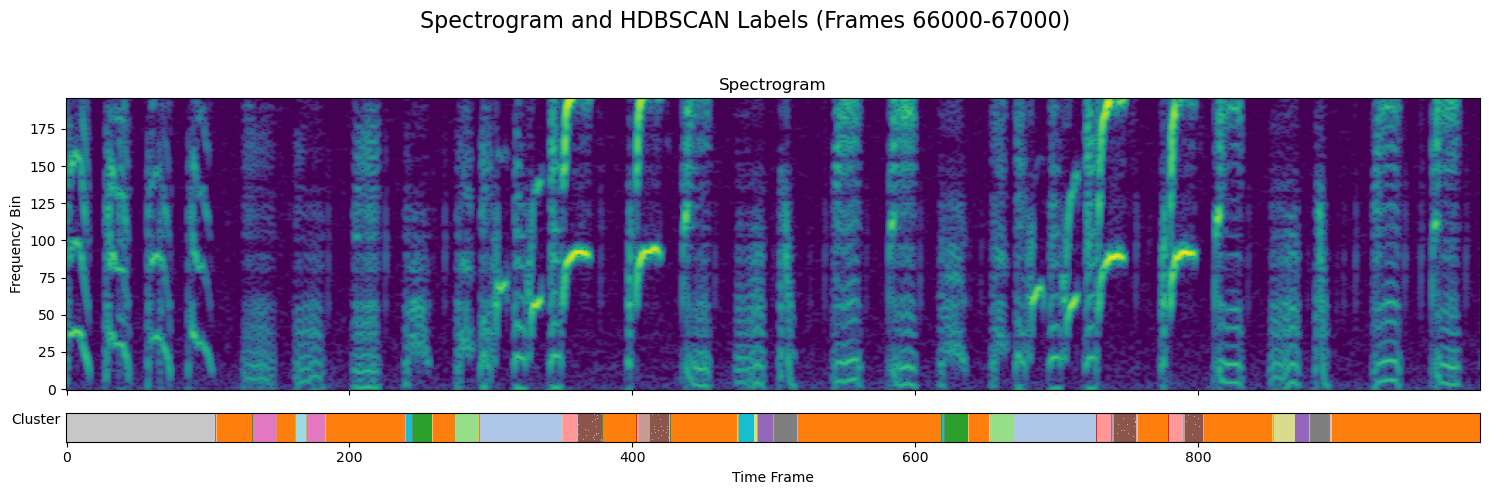

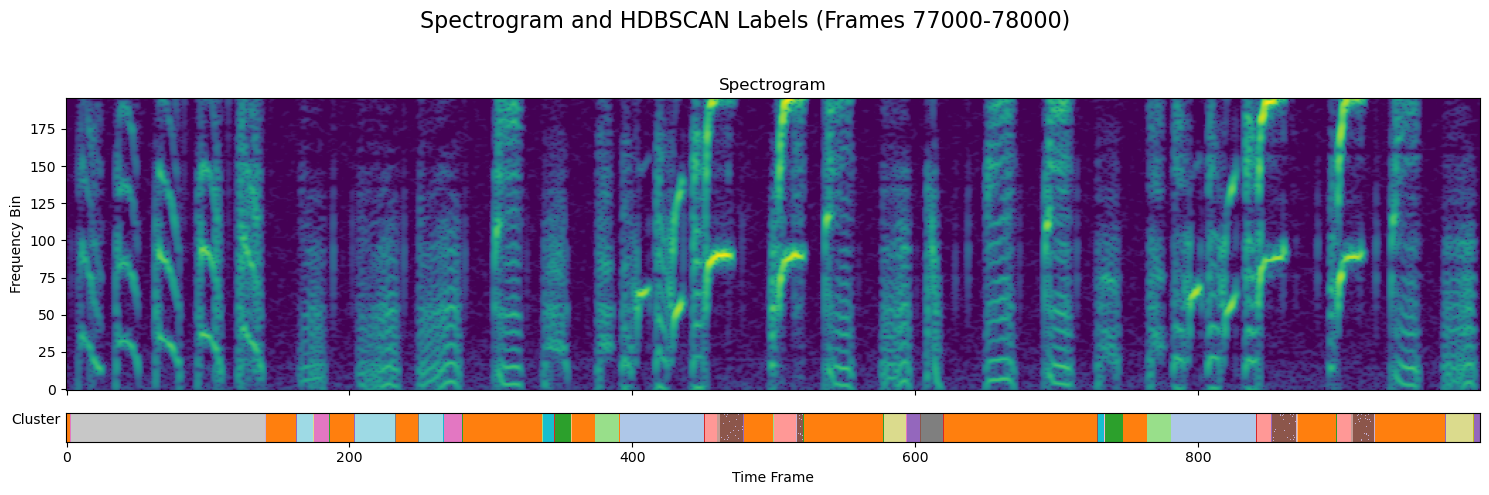

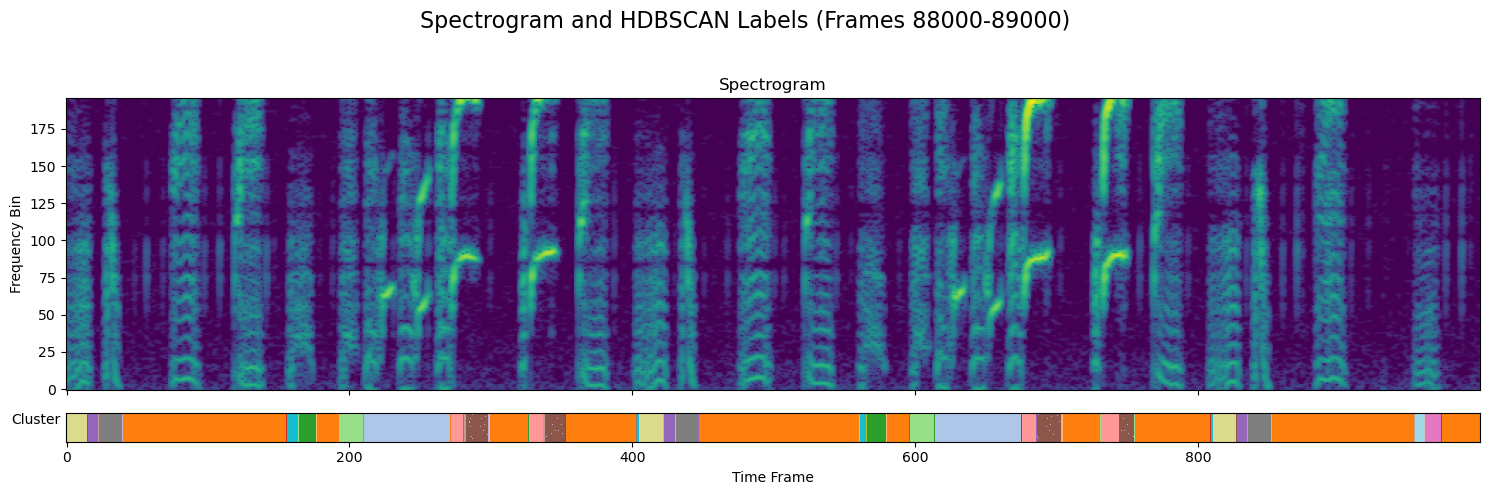

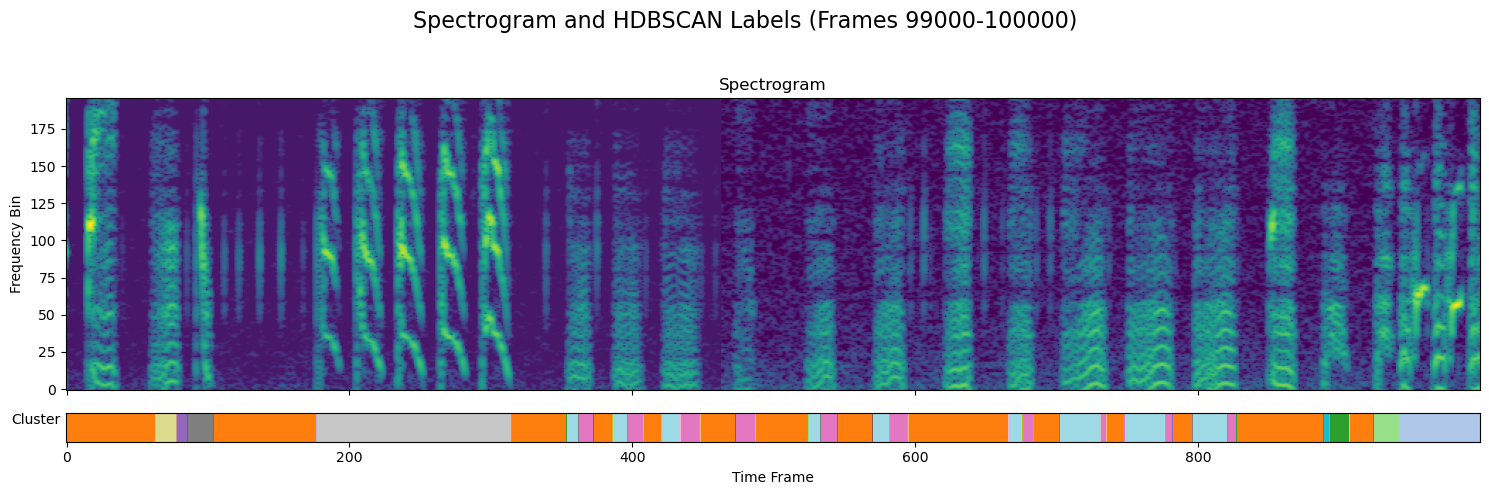

: 

In [47]:
# %% [third cell] Visualize multiple spectrogram segments with corresponding cluster labels

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# ───────────────────── CONFIG ──────────────────────
N_PLOTS = 10
VIZ_LENGTH = 1000  # Number of frames to show per plot
SMOOTH_WINDOW = 20  # Window size for max smoothing

# Compute evenly spaced start frames across the spectrogram
total_frames = len(spectogram)
if total_frames < VIZ_LENGTH:
    raise ValueError("Spectrogram is shorter than VIZ_LENGTH.")

step = (total_frames - VIZ_LENGTH) // (N_PLOTS - 1) if N_PLOTS > 1 else 0
start_frames = [i * step for i in range(N_PLOTS)]

for idx, VIZ_START_FRAME in enumerate(start_frames):
    # Ensure the requested slice is within the data bounds
    if VIZ_START_FRAME + VIZ_LENGTH > total_frames:
        VIZ_START_FRAME = total_frames - VIZ_LENGTH

    # 1) Slice the spectrogram and cluster labels
    spec_segment = spectogram[VIZ_START_FRAME : VIZ_START_FRAME + VIZ_LENGTH]
    label_segment = cluster_labels_enc[VIZ_START_FRAME : VIZ_START_FRAME + VIZ_LENGTH]

    # --- Apply max smoothing to the label segment ---
    def max_smooth(arr, window):
        # Pad with -1 (noise label) at both ends to preserve length
        pad_width = window // 2
        padded = np.pad(arr, (pad_width, pad_width), mode='constant', constant_values=-1)
        smoothed = np.empty_like(arr)
        for i in range(len(arr)):
            window_vals = padded[i:i+window]
            # Exclude -1 (noise) if possible, otherwise keep -1
            valid = window_vals[window_vals != -1]
            if valid.size > 0:
                # Use the most frequent label in the window (mode), breaking ties by max label
                vals, counts = np.unique(valid, return_counts=True)
                max_count = counts.max()
                candidates = vals[counts == max_count]
                smoothed[i] = candidates.max()
            else:
                smoothed[i] = -1
        return smoothed

    label_segment_smoothed = max_smooth(label_segment, SMOOTH_WINDOW)

    # 2) Set up the plot layout
    fig, (ax1, ax2) = plt.subplots(
        2, 1,
        figsize=(15, 5),
        sharex=True,
        gridspec_kw={'height_ratios': [10, 1]}
    )
    fig.suptitle(f'Spectrogram and HDBSCAN Labels (Frames {VIZ_START_FRAME}-{VIZ_START_FRAME+VIZ_LENGTH})', fontsize=16)

    # 3) Plot the spectrogram segment
    ax1.imshow(spec_segment.T, aspect='auto', origin='lower', cmap='viridis')
    ax1.set_ylabel('Frequency Bin')
    ax1.set_title('Spectrogram')

    # 4) Plot the cluster label bar (smoothed)
    cmap_name = 'tab20'
    cmap = plt.get_cmap(cmap_name)
    norm = mcolors.Normalize(vmin=-1, vmax=cluster_labels_enc.max())
    ax2.imshow(label_segment_smoothed[np.newaxis, :], aspect='auto', cmap=cmap, norm=norm)
    ax2.set_xlabel('Time Frame')
    ax2.set_ylabel('Cluster', rotation=0, ha='right')
    ax2.set_yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Grid Search

In [ ]:
# %% cell: Triplet grid-search + UMAP/HDBSCAN evaluation
import os, math, itertools, random
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import umap, hdbscan, matplotlib.pyplot as plt

# ─────────────── CONFIG ──────────────
NPZ_PATH      = "files/BF_nickle.npz"
ARRAY_KEY     = "predictions"
LABEL_KEY     = "ground_truth_labels"
OUT_ROOT      = "./triplet_grid"

# UMAP / HDBSCAN eval (unchanged)
N_SAMPLES     = 100_000
UMAP_KWARGS   = dict(n_components=2, n_neighbors=30,
                     metric="cosine", min_dist=0.0,
                     low_memory=True, n_jobs=-1)
HDBSCAN_KWARGS= dict(min_cluster_size=1000, min_samples=50, metric="euclidean")

BATCH_SIZE    = 4096
LR            = 5e-3
MARGIN        = 1.0          # <- triplet margin
NEG_OFFSET    = 1000         # frames must be this far to be a negative
BATCH_DEVICE  = 'cuda' if torch.cuda.is_available() else 'cpu'
DIM_IN        = None   # will be set once we load data
HIDDEN_DIM    = 256
PROJ_DIM      = 256

param_space = {
    "NOISE_STD":  [0.02, 0.05, 0.08, 0.15],
    "DROPOUT_P":  [0.0, 0.1, 0.3, 0.5],
    "MARGIN":     [0.5, 0.75, 1.0, 1.25],
}
N_TRIALS = 100                 # random-search instead of exhaustive grid

# 1) load raw data for sampling
npz = np.load(NPZ_PATH)
arr = npz[ARRAY_KEY].astype(np.float32, copy=False)
labels = (npz[LABEL_KEY].astype(int, copy=False)
          if LABEL_KEY and LABEL_KEY in npz else None)
DIM_IN = arr.shape[1]

# 2) dataset + augmentations
class TripletDataset(Dataset):
    """anchor = raw frame, positive = aug(anchor), negative = far frame"""
    def __init__(self, tensor, σ, p, k):
        self.tensor, self.K = tensor, k
        self.aug = nn.Sequential(AddGaussianNoise(σ), RandomDropout(p))
        self.N = tensor.size(0)
    def __len__(self): return self.N
    def __getitem__(self, i):
        anchor = self.tensor[i]
        positive = self.aug(anchor.clone())
        j = (i + torch.randint(self.K, self.N - self.K, ()).item()) % self.N
        negative = self.tensor[j]
        return anchor, positive, negative

class AddGaussianNoise(nn.Module):
    def __init__(self, std): super().__init__(); self.std = std
    def forward(self, x): return x + torch.randn_like(x)*self.std

class RandomDropout(nn.Module):
    def __init__(self, p): super().__init__(); self.p = p
    def forward(self, x):
        if not self.training or self.p==0: return x
        mask = torch.rand_like(x) > self.p
        return x * mask / (1 - self.p)

# 3) model defs
class Encoder(nn.Module):
    def __init__(self, dim_in, dim_hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_in, dim_hidden),
            nn.BatchNorm1d(dim_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden)
        )
    def forward(self, x): return self.net(x)

class ProjectionHead(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim_in, dim_in),
            nn.ReLU(inplace=True),
            nn.Linear(dim_in, dim_out)
        )
    def forward(self, x):
        return nn.functional.normalize(self.mlp(x), dim=-1)

# 4) triplet loss
def triplet_loss(a, p, n, margin):
    d_ap = (a - p).pow(2).sum(1)
    d_an = (a - n).pow(2).sum(1)
    return torch.relu(d_ap - d_an + margin).mean()

# 5) training + eval loop
def run_config(cfg):
    σ       = cfg["NOISE_STD"]
    p       = cfg["DROPOUT_P"]
    margin  = cfg["MARGIN"]
    epochs  = 50
    name    = f"σ{σ}_p{p}_m{margin}_ep{epochs}"
    out_dir = os.path.join(OUT_ROOT, name)
    os.makedirs(out_dir, exist_ok=True)

    tensor = torch.from_numpy(arr)
    ds = TripletDataset(tensor, σ, p, NEG_OFFSET)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True,
                    drop_last=True, num_workers=0, pin_memory=True)

    enc  = Encoder(DIM_IN, HIDDEN_DIM).to(BATCH_DEVICE)
    proj = ProjectionHead(HIDDEN_DIM, PROJ_DIM).to(BATCH_DEVICE)
    opt  = torch.optim.AdamW(list(enc.parameters())+list(proj.parameters()), lr=LR)
    scaler = torch.cuda.amp.GradScaler(enabled=(BATCH_DEVICE=='cuda'))

    losses = []
    best_loss = float('inf')
    patience = 4
    no_improve_count = 0
    
    for ep in range(1, epochs+1):
        enc.train(); proj.train()
        total = 0.0
        for a, p_, n in dl:
            a = a.to(BATCH_DEVICE, non_blocking=True)
            p_ = p_.to(BATCH_DEVICE, non_blocking=True)
            n = n.to(BATCH_DEVICE, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.autocast(BATCH_DEVICE, torch.float16, enabled=(BATCH_DEVICE=='cuda')):
                z_a = proj(enc(a))
                z_p = proj(enc(p_))
                z_n = proj(enc(n))
                loss = triplet_loss(z_a, z_p, z_n, cfg["MARGIN"])
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            total += loss.item()
        avg = total/len(dl)
        losses.append(avg)
        print(f"[{name}] ep {ep}/{epochs} loss={avg:.4f}")
        
        # Early stopping check
        if avg < best_loss:
            best_loss = avg
            no_improve_count = 0
        else:
            no_improve_count += 1
            
        if no_improve_count >= patience:
            print(f"[{name}] Early stopping at epoch {ep} (no improvement for {patience} epochs)")
            break

    torch.save(enc.state_dict(), os.path.join(out_dir, "encoder.pt"))

    idx = np.random.choice(len(arr), size=min(N_SAMPLES, len(arr)), replace=False)
    sub = arr[idx]
    with torch.inference_mode():
        E = []
        for i in range(0, sub.shape[0], BATCH_SIZE):
            x = torch.from_numpy(sub[i:i+BATCH_SIZE]).to(BATCH_DEVICE).float()
            E.append(enc(x).cpu())
        latent_enc = torch.cat(E).numpy()

    umap_2d = umap.UMAP(**UMAP_KWARGS).fit_transform(latent_enc)
    cl = hdbscan.HDBSCAN(**HDBSCAN_KWARGS).fit_predict(umap_2d)

    fig, axs = plt.subplots(1,2,figsize=(14,6))
    axs[0].scatter(umap_2d[:,0], umap_2d[:,1], c=cl, cmap="tab20", s=3, alpha=0.6)
    axs[0].set_title("Clusters"); axs[0].set_xlabel("UMAP-1"); axs[0].set_ylabel("UMAP-2")
    if labels is not None:
        axs[1].scatter(umap_2d[:,0], umap_2d[:,1], c=labels[idx],
                       cmap="tab20", s=3, alpha=0.25)
        axs[1].set_title("Ground truth")
    else:
        axs[1].axis('off')
    plt.tight_layout()
    fig.savefig(os.path.join(out_dir, "umap.png"), dpi=150)
    plt.close(fig)

# 6) launch random search
all_keys = list(param_space.keys())
for t in range(N_TRIALS):
    cfg = {k: random.choice(v) for k, v in param_space.items()}
    run_config(cfg)

print("✅ Grid-search complete; see subfolders of", OUT_ROOT)


## Visualize Neural States

In [ ]:
# %% cell: visualize latent-space cosine similarity under stored spectrogram
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

# ───── CONFIG ─────
NPZ_PATH    = "files/BF_nickle.npz"
LATENT_KEY  = "predictions"   # TweetyBERT latents, shape (T, D)
SPECT_KEY   = "s"             # spectrogram frames, shape (T, F)

# ─── load data ───
data = np.load(NPZ_PATH)
arr = data[LATENT_KEY].astype(np.float32)  # (T, D)
S   = data[SPECT_KEY].astype(np.float32)   # (T, F)

# ─── z-score the neural states ───
arr = (arr - np.mean(arr, axis=0)) / np.std(arr, axis=0)

# ─── compute cosine similarity to previous time-bin ───
T, D = arr.shape
sim = np.empty(T, dtype=np.float32)
sim[0] = np.nan
for t in range(1, T):
    a, b = arr[t], arr[t-1]
    sim[t] = np.dot(a, b) / (norm(a) * norm(b))

# ─── plot spectrogram + similarity for every 1000 time bins ───
n_plots = 10
bins_per_plot = 1000

for plot_idx in range(n_plots):
    start_idx = plot_idx * bins_per_plot
    end_idx = min(start_idx + bins_per_plot, T)
    
    if start_idx >= T:
        break
        
    # Extract data for this window
    S_window = S[start_idx:end_idx]
    sim_window = sim[start_idx:end_idx]
    time_indices = np.arange(start_idx, end_idx)
    
    fig, (ax_sp, ax_sim) = plt.subplots(
        nrows=2, ncols=1,
        sharex=True,
        figsize=(12, 6),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # 1) spectrogram (transpose so freq on y-axis)
    img = ax_sp.imshow(
        S_window.T,
        aspect="auto",
        origin="lower",
        interpolation="nearest",
        extent=[start_idx, end_idx-1, 0, S.shape[1]-1]
    )
    ax_sp.set(title=f"Spectrogram from NPZ (bins {start_idx}-{end_idx-1})", ylabel="Freq bin")

    # 2) similarity trace
    ax_sim.plot(time_indices, sim_window, marker=".", linestyle="-", linewidth=1)
    ax_sim.set(
        title="Cosine Similarity to Previous Time-Bin",
        xlabel="Time bin index",
        ylabel="Cosine similarity"
    )
    ax_sim.set_ylim(-1.0, 1.0)

    plt.tight_layout()
    plt.show()


## removing positional information!

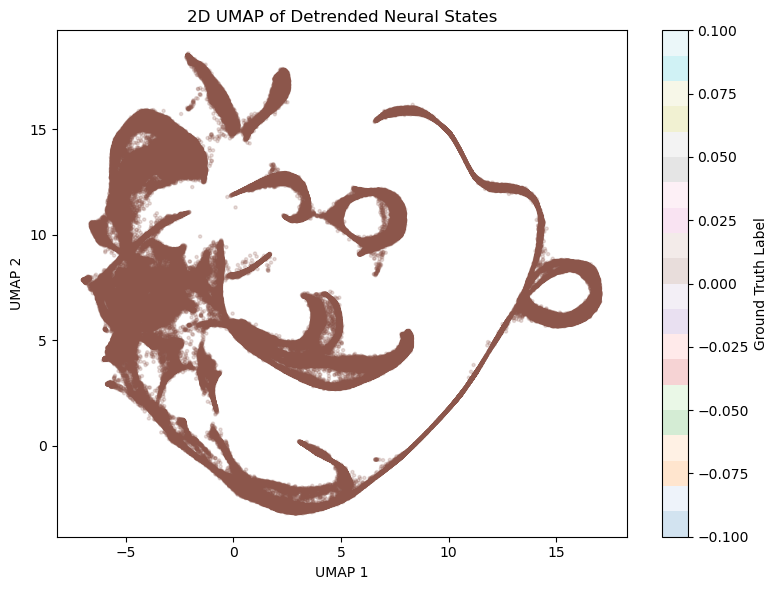

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import umap

f = np.load("files/BF_nickle.npz", allow_pickle=True)
embedding = f["embedding_outputs"][:200_000]
neural_states = f["predictions"][:200_000]
spectrogram = f["s"][:200_000]
ground_truth = f["ground_truth_labels"][:200_000]
file_indices = f["file_indices"][:200_000]

# 1. Compute position within each file
pos_in_file = np.zeros_like(file_indices)
for file_id in np.unique(file_indices):
    idx = np.where(file_indices == file_id)[0]
    pos_in_file[idx] = np.arange(len(idx))

# 2. Compute segment-relative position via modulo
seg_pos = pos_in_file % 1000

# 3. Estimate mean bias per relative position
D = neural_states.shape[1]
mean_bias = np.zeros((1000, D), dtype=np.float32)
for k in range(1000):
    mask = (seg_pos == k)
    if np.any(mask):
        mean_bias[k] = neural_states[mask].mean(axis=0)

# 4. Subtract positional bias to get residuals
detrended = neural_states - mean_bias[seg_pos]

# 5. Run UMAP on residuals
umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    metric="cosine",
    n_jobs=-1,
    low_memory=True
).fit_transform(detrended)

# 6. Plot UMAP colored by ground truth
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    umap_2d[:, 0],
    umap_2d[:, 1],
    c=ground_truth,
    cmap="tab20",
    s=5,
    alpha=0.2
)
plt.colorbar(scatter, label="Ground Truth Label")
plt.title("2D UMAP of Detrended Neural States")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()
